In [2]:
import re
import os
import gzip

import HTSeq

from collections import defaultdict
from collections import OrderedDict

import matplotlib.pyplot as plt

## Remove 3' and 5' linkers using cutadapt

In [32]:
adapter1 = input('3\' adapter:')

3' adapter:CGAAACACCG


In [33]:
adapter2 = input('5\' adapter:')

5' adapter:GTTTTAGAGC


In [4]:
adapter = adapter1+'...'+adapter2

In [5]:
adapter

'CGAAACACCG...GTTTTAGAGC'

In [12]:
os.system('cutadapt -j 2 -g ' + adapter + ' -e 0.1 --no-indels \
          -o crispr.sample.cutadapt.fq.gz \
          crispr.sample.fq.gz \
          > crispr.sample.report.txt')

0

## Length distribution of the processed reads

In [3]:
i = 0

stat = {}

with gzip.open('crispr.sample.cutadapt.fq.gz', 'rt') as f:
    for line in f:
        line = line.rstrip()
        i += 1
        
        if i % 4 == 2:
            if len(line) not in stat.keys():
                stat[len(line)] = 0
            stat[len(line)] += 1

In [9]:
sorted(stat.items(), key=lambda x:x[1], reverse=True)

[(20, 4012),
 (19, 328),
 (21, 60),
 (16, 58),
 (22, 14),
 (18, 11),
 (28, 6),
 (15, 4),
 (17, 4),
 (30, 4),
 (31, 4),
 (25, 3),
 (26, 3),
 (1, 1),
 (35, 1),
 (38, 1),
 (49, 1),
 (8, 1),
 (24, 1),
 (29, 1)]

<Container object of 20 artists>

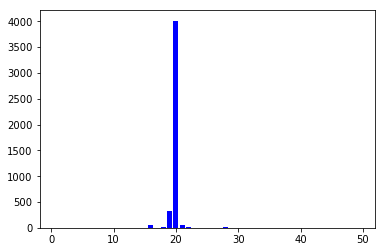

In [6]:
%matplotlib inline

plt.bar(list(stat.keys()), list(stat.values()), align='center', color='blue')

## Only keep reads of 20nt

In [19]:
fh = gzip.open('crispr.sample.cutadapt.20.fq.gz', 'wt')

i = 0
with gzip.open('crispr.sample.cutadapt.fq.gz', 'rt') as f:
    for line in f:
        line = line.rstrip()
        i += 1
        
        if i % 4 == 1:
            seqID = line
        
        if i % 4 == 2:
            seq = line
            
        if i % 4 == 0:
            qual = line
            
            if len(line) == 20:
                fh.write('\n'.join([seqID, seq, '+', qual])+'\n')
            
            #if len(line) in range(19,22):
            #    fh.write('\n'.join([seqID, seq, '+', qual])+'\n')
                
fh.close()

## Alignment using bowtie2

### build index

In [33]:
os.system('bowtie2-build GeckoV2_HGLib_All.fa GeckoV2_HGLib_All')

0

### alignment

In [21]:
os.system('bowtie2 -L 2O -N 1 -p 4 -x GeckoV2_HGLib_All \
        -U crispr.sample.cutadapt.20.fq.gz \
        -S crispr.sample.cutadapt.20.sam')

0

## Count the number of mapped sgRNAs for each gene by HTSeq

In [8]:
X = HTSeq.SAM_Reader( "crispr.sample.cutadapt.20.sam")
counts = defaultdict( lambda: 0 )
for almnt in X:
    if almnt.aligned:
        counts[almnt.iv.chrom] += 1

In [9]:
sorted(counts.items(), key=lambda x:x[1], reverse=True)[:10]

[('hsa-mir-1181|HGLibA_57216|TGTAGTCCACCATCTTGCCT', 68),
 ('MIER2|HGLibA_29256|TCTCTGCGAGGTTGAACTGA', 67),
 ('DAO|HGLibA_12309|AATAAACTCACCCGTAATCT', 66),
 ('PIM2|HGLibA_36679|AGCCACGGCGTAGGTCTATC', 60),
 ('SLC2A4|HGLibA_44876|TACCTGAGTAGGCGCCAATG', 51),
 ('NIF3L1|HGLibA_31930|TCTCATATTCGCTTAGCCCT', 50),
 ('CTSO|HGLibA_11726|GAAAACTCCACCGCCTTCTA', 45),
 ('GRIK4|HGLibA_20289|TGGAACTTGACGAACTCCTC', 41),
 ('RSPO3|HGLibA_42349|GTGCATCCTAACGTTAGTCA', 40),
 ('hsa-mir-15a|HGLibA_57939|TGTGCTGCTACTTTACTCCA', 38)]

## Report counts data

In [11]:
ko = OrderedDict()
ctrl = OrderedDict()
with open('GeckoV2_HGLib_All.fa') as f:
    for line in f:
        line = line.rstrip()
        if not line.startswith('>'):
            continue
            
        line = line.replace('>', '')
        lst = line.split('|')
        
        if lst[0].startswith('NonTargetingControlGuideForHuman'):
            ctrl[line] = lst
            
        else:
            ko[line] = lst
            
ko = OrderedDict(sorted(ko.items()))
ctrl = OrderedDict(sorted(ctrl.items(), key=lambda x:x[1][0]))

In [14]:
list(ko.items())[:10]

[('A1BG|HGLibA_00001|GTCGCTGAGCTCCGATTCGA',
  ['A1BG', 'HGLibA_00001', 'GTCGCTGAGCTCCGATTCGA']),
 ('A1BG|HGLibA_00002|ACCTGTAGTTGCCGGCGTGC',
  ['A1BG', 'HGLibA_00002', 'ACCTGTAGTTGCCGGCGTGC']),
 ('A1BG|HGLibA_00003|CGTCAGCGTCACATTGGCCA',
  ['A1BG', 'HGLibA_00003', 'CGTCAGCGTCACATTGGCCA']),
 ('A1BG|HGLibB_00001|CAATGTGACGCTGACGTGCC',
  ['A1BG', 'HGLibB_00001', 'CAATGTGACGCTGACGTGCC']),
 ('A1BG|HGLibB_00002|TGTCTCCGCAGGTGTCACCT',
  ['A1BG', 'HGLibB_00002', 'TGTCTCCGCAGGTGTCACCT']),
 ('A1BG|HGLibB_00003|CATATGGCTGCTTCTGTCAC',
  ['A1BG', 'HGLibB_00003', 'CATATGGCTGCTTCTGTCAC']),
 ('A1CF|HGLibA_00004|CGCGCACTGGTCCAGCGCAC',
  ['A1CF', 'HGLibA_00004', 'CGCGCACTGGTCCAGCGCAC']),
 ('A1CF|HGLibA_00005|CCAAGCTATATCCTGTGCGC',
  ['A1CF', 'HGLibA_00005', 'CCAAGCTATATCCTGTGCGC']),
 ('A1CF|HGLibA_00006|AAGTTGCTTGATTGCATTCT',
  ['A1CF', 'HGLibA_00006', 'AAGTTGCTTGATTGCATTCT']),
 ('A1CF|HGLibB_00004|GGTGCAGCATCCCAACCAGG',
  ['A1CF', 'HGLibB_00004', 'GGTGCAGCATCCCAACCAGG'])]

In [32]:
fh = open('crispr.sample.cutadapt.20.Counts', 'wt')


for ke in ko.keys():
    iid = ke.replace('|', '\t')
    
    if ke not in counts.keys():
        fh.write(iid+'\t'+'0'+'\n')
        
    else:
        fh.write(iid+'\t'+str(counts[ke])+'\n')
        
        
for ke in ctrl.keys():
    iid = ke.replace('|', '\t')
    
    if ke not in counts.keys():
        fh.write(iid+'\t'+'0'+'\n')
        
    else:
        fh.write(iid+'\t'+str(counts[ke])+'\n')

        
fh.close()